In [11]:
# imports
import pandas as pd
from path import Path
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import networkx as nx

In [12]:
RANDOM_STATE = 21


In [13]:
path_to_processed_data = Path.joinpath("..",
    "data", "processed"
)
path_to_result_data = Path.joinpath("..",
    "reports", "figures"
)

In [14]:
df = pd.read_csv(Path.joinpath(path_to_processed_data, "var_model.csv"),
                 names=["x" + str(i) for i in range(10)])
df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,0.604153,0.090093,0.216768,0.202941,0.429920,0.474736,0.454454,0.270494,0.388146,0.557153
1,0.291600,0.474110,0.364126,0.501416,0.165009,0.463155,0.810471,0.607899,0.663754,0.265945
2,0.283553,0.251639,-0.070440,0.393409,0.593209,0.515867,0.069845,0.372466,0.479233,0.236428
3,0.523550,0.278415,0.573935,0.416608,0.571024,0.592840,0.559031,0.601879,0.263178,0.407308
4,0.567769,0.275094,0.495152,0.294343,0.252798,0.339205,0.387398,0.423862,0.217718,0.161125
...,...,...,...,...,...,...,...,...,...,...
995,0.424880,0.361032,0.115893,0.676581,0.301261,0.339265,0.316436,0.523744,0.357936,0.504680
996,0.597716,0.167018,0.653856,0.439426,0.644208,0.640138,0.841366,0.466130,0.421951,0.514413
997,0.461512,0.429274,0.440212,0.453659,0.437023,0.237474,0.166492,0.368079,0.315754,0.534026
998,0.542612,0.455465,0.413267,0.346621,0.483384,0.298032,0.564474,0.197096,0.652859,0.407652


In [15]:
target_vars = ["x7", "x9"]

<h4> TLCC </h4>
Применим TLCC к VAR модели:

In [16]:
def crosscorr(datax: pd.Series, datay: pd.Series, maxlag: int) -> pd.DataFrame:
    """ Lag-N cross correlation. 

    Parameters
    ----------
    maxlag : int
    datax, datay : pd.Series objects of equal length
    Returns
    ----------
    crosscorr : pd.DataFrame with columns ['lag', 'pearson', 'p-value']
    """
    if datax.size != datay.size:
        return np.nan
        
    corr_list = [[lag, *datax.corr(datay.shift(lag), method=lambda x, y: pearsonr(x, y))] 
                for lag in range(1, maxlag+1)]
    return pd.DataFrame(corr_list, columns=['lag', 'pearson', 'p-value'])


Иногда TLCC способен уловить какие-то связи между рядами, как в этом случае:

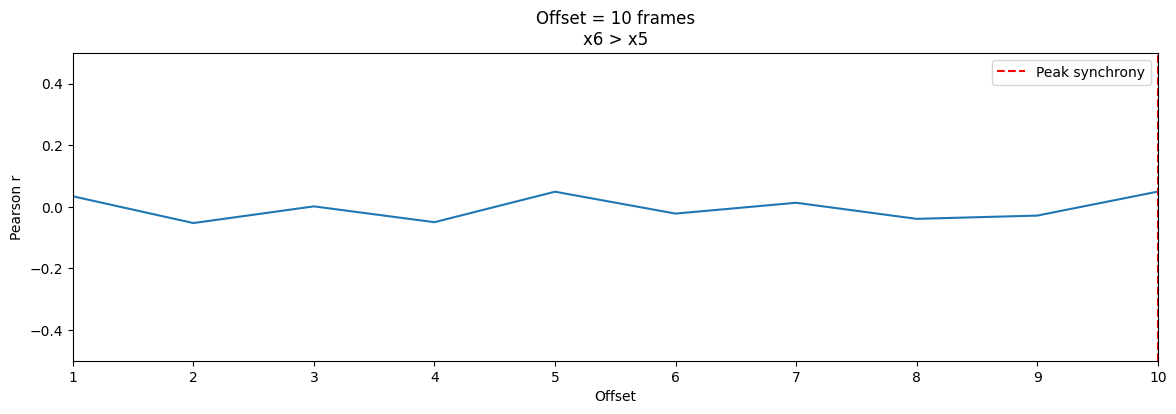

In [17]:
days = 10
corr = crosscorr(df.x5, df.x6, days)
x = [i for i in range(1, days+1)]
offset = np.argmax(corr.pearson) + 1
f,ax=plt.subplots(figsize=(14,4))
ax.plot(x, corr.pearson)
ax.axvline(offset,color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nx6 > x5',ylim=[-0.5,0.5],xlim=[1,10], xlabel='Offset',ylabel='Pearson r')

plt.legend()
#plt.savefig(results_path)

In [18]:
corr[corr['p-value']<1e-2]

,lag,pearson,p-value


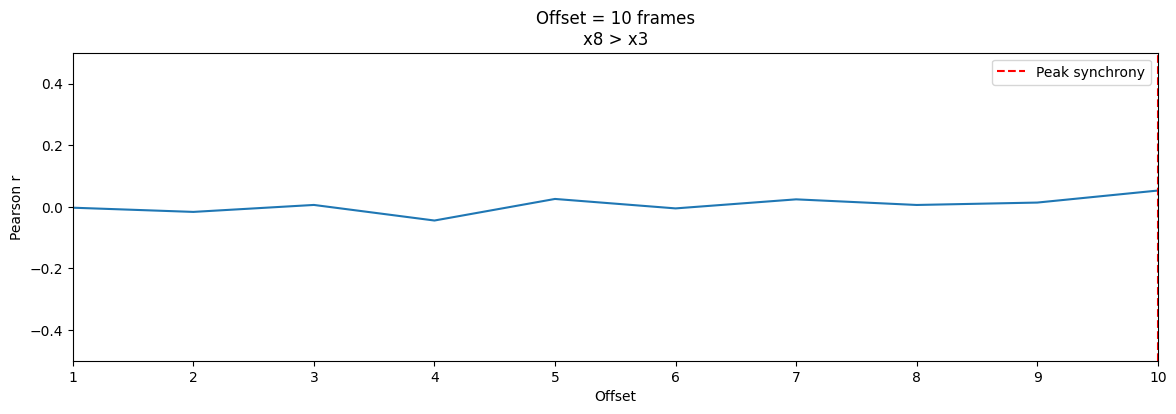

In [19]:
corr = crosscorr(df.x3, df.x8, days)
offset = np.argmax(corr.pearson) + 1
f,ax=plt.subplots(figsize=(14,4))
ax.plot(x, corr.pearson)
ax.axvline(offset,color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nx8 > x3',ylim=[-0.5,0.5],xlim=[1,10], xlabel='Offset',ylabel='Pearson r')
plt.legend()
results_path = Path.joinpath(
    path_to_result_data,
    "tlcc_x3_x8.png",
)
#plt.savefig(results_path)

In [20]:
corr[corr['p-value']<1e-2]

,lag,pearson,p-value


Найдем наиболее связанные скважины по всему датасету. Поскольку связей и лагов может быть несколько, то будем считать связанными все скважины, для которых p-value < 1e-2. 

In [21]:
def tlcc(data: pd.DataFrame, targets: list, maxlag: int, pval= 1e-2) -> pd.DataFrame:
    """ Lag-N cross correlation. 

    Parameters
    ----------
    data : pd.DataFrame 
    maxlag : int
    Returns
    ----------
    res_df : pd.DataFrame with columns ['vars', 'lag', 'pearson', 'p-value']
    """
    res_df = pd.DataFrame(columns=['vars', 'lag', 'pearson', 'p-value'])
    cols = data.columns
    for col_i in cols:
        for col_j in targets:
            if col_i != col_j and col_i in targets:
                continue
            corr_df = crosscorr(data[col_i], data[col_j], days)
            vars_col = [(col_i, col_j) for k in range(corr_df.shape[0])]
            corr_df.insert(0, "vars", vars_col, True)
            corr_df['lag'] = corr_df['lag'].abs()
            res_df = pd.concat([res_df, corr_df])
    res_df = res_df[res_df['p-value']<pval].drop_duplicates()
    return res_df.reset_index(drop=True)

In [22]:
tlcc_results = tlcc(df, target_vars, days, 5e-2)

C:\Users\sonyi\AppData\Local\Temp\ipykernel_24404\954399600.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df, corr_df])


In [23]:
tlcc_results


,vars,lag,pearson,p-value
0,"(x0, x9)",6,0.067300,0.033876
1,"(x0, x9)",10,0.067494,0.033722
2,"(x1, x7)",1,-0.062720,0.047494
3,"(x1, x7)",2,0.072795,0.021457
4,"(x1, x7)",8,0.064581,0.041991
5,"(x2, x9)",6,0.091964,0.003709
6,"(x2, x9)",8,0.067947,0.032367
7,"(x3, x9)",3,-0.066102,0.036900
8,"(x3, x9)",4,0.080630,0.010909
9,"(x4, x9)",5,-0.070600,0.025949


In [24]:
def draw_labeled_multidigraph(G, attr_name, rad=0.2, ax=None):               
    pos = nx.shell_layout(G)

    connectionstyle=f"arc3,rad=" + str(rad)
    plt.figure(figsize=(8,8))
    nx.draw_networkx_nodes(G, pos, alpha=0.9, node_color='pink')
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, connectionstyle=connectionstyle, arrows=True)
    
    labels = {}
    for *edge, attrs in G.edges(keys=True, data=True):
        labels.update({
                tuple(edge): ', '.join(f'{attr}' for attr in attrs[attr_name])})
    nx.draw_networkx_edge_labels(
        G, pos, 
        connectionstyle=connectionstyle,
        edge_labels=labels,
        font_color='red',
        label_pos=0.75,
        font_size=9
    )
    

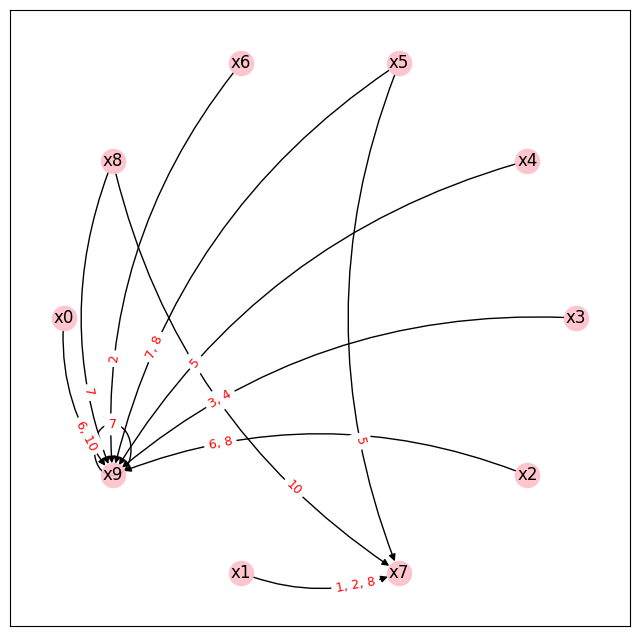

In [25]:
tlcc_short = tlcc_results.groupby('vars').\
                   agg(lags = ('lag', list)).reset_index()

G = nx.MultiDiGraph()

edge_labels = dict(zip(tlcc_short.vars.values, tlcc_short.lags.values))

for (pairs, weight) in edge_labels.items():
    G.add_edge(pairs[0], pairs[1], w=weight)

draw_labeled_multidigraph(G, "w")

<h4> RFE (Recursive feature elemination) </h4>
Применим RFE к VAR модели:

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

In [27]:
def shiftedDF(data: pd.Series, name: str, maxlag: int) -> pd.DataFrame:
    """ 
    Returns shifted data from -maxlag to maxlag (included)
    Parameters
    ----------
    data : pd.Series 
    maxlag : int
    Returns
    ----------
    df : pd.DataFrame
    """
    df = pd.DataFrame()
    ran = [i for i in range(1, maxlag+1)]
    for i in ran:
        df[name + ':' +str(i)] = data.shift(i)
    df = df[maxlag:]
    return df

In [28]:
def rfe(data: pd.DataFrame, targets: list, maxlag: int, n_features_to_select= 5) -> pd.DataFrame:
    """ Recursive feature selection. 

    Parameters
    ----------
    data : pd.DataFrame 
    maxlag : int
    n_features_to_select : int
    Returns
    ----------
    res_df : pd.DataFrame with columns ['vars', 'lag']
    """
    res_df = pd.DataFrame(columns=['vars', 'lag'])
    cols = data.columns

    for col_i in targets:
        X = pd.DataFrame()
        for col_j in cols:
            if col_i != col_j and col_j in targets:
                continue
            X = pd.concat([X, shiftedDF(data[col_j], col_j, maxlag)], axis = 1)
        y = data[col_i][:-maxlag]
        
        rfe = RFE(RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE), n_features_to_select=n_features_to_select)
        fit = rfe.fit(X, y)

        sub_df = pd.DataFrame(columns=['vars', 'lag'])
        for place in np.where(fit.support_)[0]:
            feature = X.columns[place]
            var, lag = feature.split(':')
            sub_df = pd.concat([sub_df,
                pd.DataFrame([{'vars' : (var,  col_i), 'lag' : abs(int(lag))}])], 
                ignore_index = True)

        res_df = pd.concat([res_df, sub_df])
    return res_df.reset_index(drop=True)


In [41]:
rfe_res = rfe(df, target_vars, days, 12)
rfe_res

,vars,lag
0,"(x0, x7)",2
1,"(x0, x7)",9
2,"(x1, x7)",7
3,"(x2, x7)",5
4,"(x3, x7)",1
5,"(x4, x7)",4
6,"(x4, x7)",6
7,"(x6, x7)",4
8,"(x6, x7)",7
9,"(x7, x7)",6


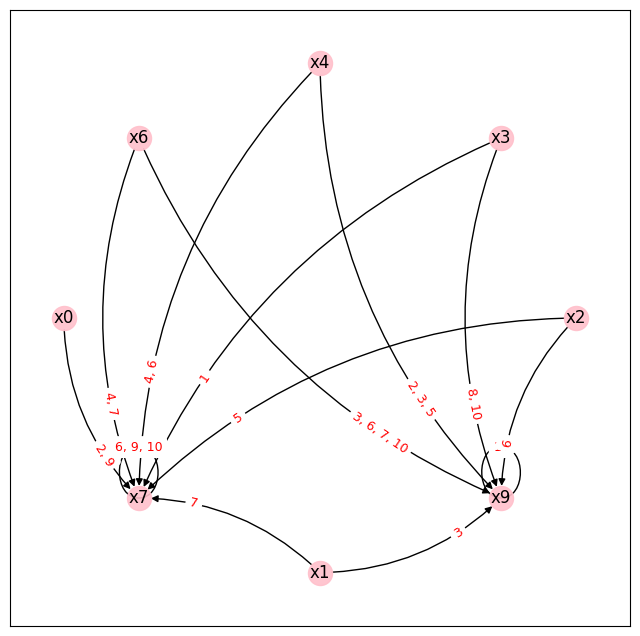

In [42]:
rfe_short = rfe_res.groupby('vars').\
                   agg(lags = ('lag', list)).reset_index()

G = nx.MultiDiGraph()

edge_labels = dict(zip(rfe_short.vars.values, rfe_short.lags.values))

for (pairs, weight) in edge_labels.items():
    G.add_edge(pairs[0], pairs[1], w=weight)

draw_labeled_multidigraph(G, "w")

In [43]:
from sklearn.feature_selection import mutual_info_regression

In [44]:
def mi(data: pd.DataFrame, targets: list, maxlag: int, n_features_to_select= 5):
    res_df = pd.DataFrame(columns=['vars', 'lag'])
    cols = data.columns
    for col_i in targets:
        X = pd.DataFrame()
        for col_j in cols:
            if col_i != col_j and col_j in targets:
                continue
            X = pd.concat([X, shiftedDF(data[col_j], col_j, maxlag)], axis = 1)
            
        y = data[col_i][:-maxlag]
        mi = mutual_info_regression(X, y, discrete_features=np.zeros(X.shape[1], dtype=bool), random_state=RANDOM_STATE)
        mi = pd.Series(mi, index = X.columns).sort_values(ascending=False).iloc[:n_features_to_select]

        sub_df = pd.DataFrame(columns=['vars', 'lag'])
        for feature, lag in mi.items():
            var, lag = feature.split(':')
            sub_df = pd.concat([sub_df,
                pd.DataFrame([{'vars' : (var, col_i), 'lag' : abs(int(lag))}])], 
                ignore_index = True)
            
        res_df = pd.concat([res_df, sub_df])

    return res_df.reset_index(drop=True)

In [45]:
mi_results = mi(df, target_vars, days, 12)
mi_results

,vars,lag
0,"(x7, x7)",10
1,"(x8, x7)",5
2,"(x3, x7)",9
3,"(x6, x7)",4
4,"(x7, x7)",3
5,"(x5, x7)",9
6,"(x2, x7)",2
7,"(x2, x7)",7
8,"(x0, x7)",5
9,"(x1, x7)",8


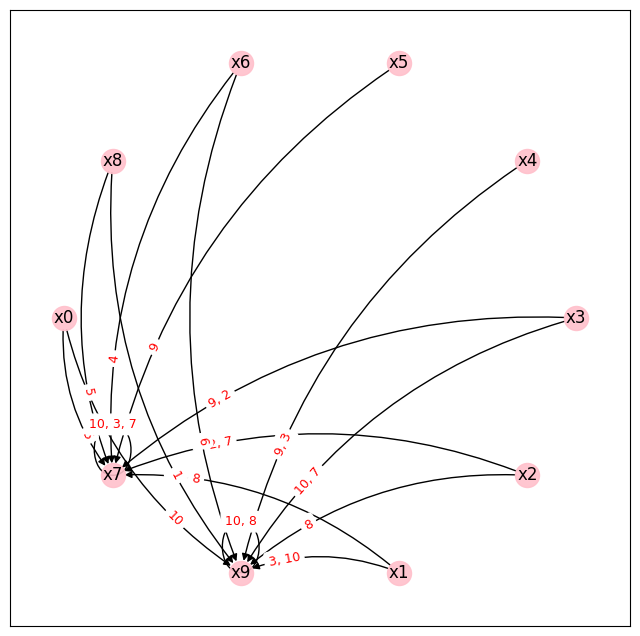

In [46]:
mi_short = mi_results.groupby('vars').\
                   agg(lags = ('lag', list)).reset_index()

G = nx.MultiDiGraph()

edge_labels = dict(zip(mi_short.vars.values, mi_short.lags.values))

for (pairs, weight) in edge_labels.items():
    G.add_edge(pairs[0], pairs[1], w=weight)

draw_labeled_multidigraph(G, "w")

In [35]:
var_model_df = pd.DataFrame(columns=['vars', 'lag'])
var_model = [
    [('x2', 'x1'), 2,], [('x1', 'x1'), 1], [('x8', 'x3'), 8], [('x3', 'x3'), 3],
    [('x5', 'x5'), 2], [('x5', 'x5'), 6], [('x1', 'x7'), 6], [('x2', 'x9'), 1],
    [('x1', 'x7'), 2], [('x5', 'x7'), 2], [('x5', 'x7'), 8], [('x7', 'x7'), 4],
    [('x8', 'x7'), 1], [('x4', 'x7'), 3], [('x4', 'x7'), 9], [('x8', 'x7'), 5],
    [('x9', 'x9'), 3], [('x3', 'x9'), 2], [('x3', 'x9'), 7], [('x6', 'x9'), 1],
    [('x6', 'x9'), 5], [('x0', 'x9'), 9], [('x0', 'x9'), 7], [('x2', 'x9'), 6],
    
]
for i in range(len(var_model)):
    var_model_df.loc[i] = var_model[i]

In [36]:
var_model_df

,vars,lag
0,"(x2, x1)",2
1,"(x1, x1)",1
2,"(x8, x3)",8
3,"(x3, x3)",3
4,"(x5, x5)",2
5,"(x5, x5)",6
6,"(x1, x7)",6
7,"(x2, x9)",1
8,"(x1, x7)",2
9,"(x5, x7)",2


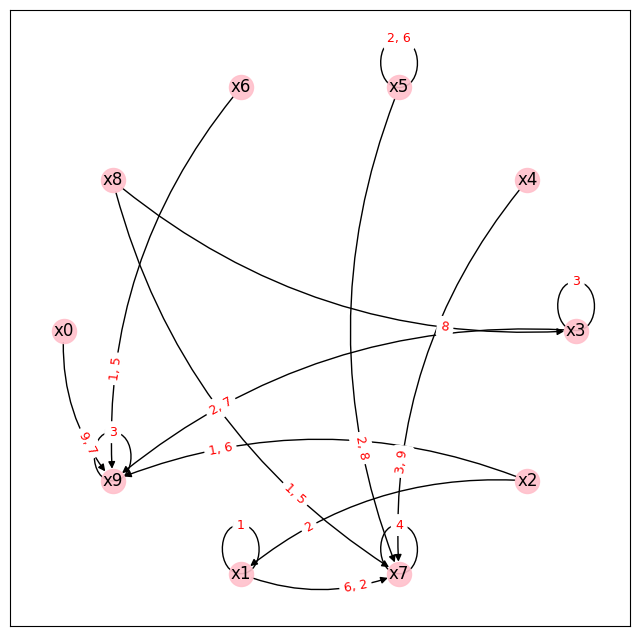

In [37]:
var_short = var_model_df.groupby('vars').\
                   agg(lags = ('lag', list)).reset_index()

G = nx.MultiDiGraph()

edge_labels = dict(zip(var_short.vars.values, var_short.lags.values))

for (pairs, weight) in edge_labels.items():
    G.add_edge(pairs[0], pairs[1], w=weight)

draw_labeled_multidigraph(G, "w")
plt.show(block=False)

In [38]:
results_path = Path.joinpath(
    path_to_result_data,
    "var_graph.png",
)
plt.savefig(results_path)

<Figure size 640x480 with 0 Axes>

In [39]:
import sys

In [40]:
nb_dir = Path.joinpath('..',
    "src"
)
src_path = os.path.abspath(nb_dir)
if src_path not in sys.path:
    sys.path.append(os.path.abspath(nb_dir))

NameError: name 'os' is not defined

In [ ]:
var_model = [
    [('x2', 'x1'), 2,], [('x1', 'x1'), 1], [('x8', 'x3'), 8], [('x3', 'x3'), 3],
    [('x5', 'x5'), 2], [('x5', 'x5'), 6], [('x1', 'x7'), 6], [('x2', 'x9'), 1],
    [('x1', 'x7'), 2], [('x5', 'x7'), 2], [('x5', 'x7'), 8], [('x7', 'x7'), 4],
    [('x8', 'x7'), 1], [('x4', 'x7'), 3], [('x4', 'x7'), 9], [('x8', 'x7'), 5],
    [('x9', 'x9'), 3], [('x3', 'x9'), 2], [('x3', 'x9'), 7], [('x6', 'x9'), 1],
    [('x6', 'x9'), 5], [('x0', 'x9'), 9], [('x0', 'x9'), 7], [('x2', 'x9'), 6],
    [('x2', 'x2'), 2], [('x2', 'x2'), 2], [('x0', 'x0'), 4], [('x0', 'x0'), 1],
    [('x4', 'x4'), 9], [('x4', 'x4'), 5], [('x6', 'x6'), 6], [('x6', 'x6'), 5],
    [('x8', 'x8'), 1], [('x8', 'x8'), 2],
    
]


In [ ]:
n = 10
GC = np.zeros((n, n))

for i in range(len(var_model)):
    driver, target = [int(var[1]) for var in var_model[i][0]]
    GC[target][driver] = 1
